<a href="https://colab.research.google.com/github/Jun-Liu-291/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/16_Natural_language_Processing_with_RNNs_and_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

     |████████████████████████████████| 1.1MB 8.6MB/s 
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Char-RNN

## Spliting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g., ```[0, 1, 2, 3, 4], [2, 3, 4, 5, 6]```, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps)(e.g., ```[2, 3, 4, 5, 6]``` would be split into ```[[2, 3, 4, 5], [3, 4, 5, 6]]```), then create batches of 3 such input/target pairs:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
  print("_" * 20, "Batch", index, "\nX_batch")
  print(X_batch.numpy())
  print("="*5, "\Y_batch")
  print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== \Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== \Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset0

In [ ]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shipfed 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
batch_size = 128
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
    )

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
  print(X_batch.shape, Y_batch.shape)

(128, 100, 39) (128, 100)


## Creating and Training the Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))

])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
7842/7842 [==============================] - 4923s 628ms/step - loss: 1.6191
Epoch 2/5
7842/7842 [==============================] - 5055s 645ms/step - loss: 1.4533
Epoch 3/5
7842/7842 [==============================] - 5097s 650ms/step - loss: 1.4236
Epoch 4/5
7842/7842 [==============================] - 5189s 662ms/step - loss: 1.4098
Epoch 5/5
7842/7842 [==============================] - 4995s 637ms/step - loss: 1.4011


## Using the Model to Generate Text

In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred+1)[0][-1] # 1st sentence, last char

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'u'

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [ ]:
# define next_char function give temperature:
# close to zero will favor the high-probability characters
# while a very high temperature will give all characters an equal probabiltiy
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("how are yo", temperature=1)

'u'

In [ ]:
# repeatedly call next_char()
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the suitors and the state,
who shall be the other a


In [ ]:
print(complete_text("t", temperature=1)) # work better

to-co be
done executed to spear:
that with the sent


In [ ]:
print(complete_text("t", temperature=2))

tpe:
but, lvy?
my? mazens?
free we deniburdy.-
mast


## Stateful RNN

until now, all the model are statelss RNNs: at each training interation the model starts with a hidden state full of zeroes, then it updates this state at each time step, and after the last time step, it throws away, as it is not needed anymore.

To learn long-term patterns despite only backpropagating through short sequences. preserve this final state after processing one trianing batch and use it as the initial state for the next training batch.

1. each input sequence in a btahc starts exactly where the corresponding sequence in the previous batch left off.

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
  dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
  dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_length))
  datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)
dataset = dataset.prefetch(1)

In [ ]:
model = keras.models.Sequential(
    [
     keras.layers.GRU(128, return_sequences=True, stateful=True,
                      dropout=0.2, recurrent_dropout=0.2,
                      batch_input_shape=[batch_size, None, max_id]),
     keras.layers.GRU(128, return_sequences=True, stateful=True,
                      dropout=0.2, recurrent_dropout=0.2),
     keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                     activation="softmax"))
    ]
)

At the end of each epoch, we need to reset the states before we go back to the beginning of the text. For this, we can use a small callback:

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 80s 256ms/step - loss: 2.6145
Epoch 2/50
313/313 [==============================] - 80s 256ms/step - loss: 2.1799
Epoch 3/50
313/313 [==============================] - 80s 257ms/step - loss: 2.5664
Epoch 4/50
313/313 [==============================] - 80s 257ms/step - loss: 2.4927
Epoch 5/50
313/313 [==============================] - 81s 258ms/step - loss: 2.2136
Epoch 6/50
313/313 [==============================] - 81s 257ms/step - loss: 2.1568
Epoch 7/50
313/313 [==============================] - 81s 258ms/step - loss: 2.0758
Epoch 8/50
313/313 [==============================] - 81s 259ms/step - loss: 1.9767
Epoch 9/50
313/313 [==============================] - 80s 257ms/step - loss: 1.9557
Epoch 10/50
313/313 [==============================] - 81s 259ms/step - loss: 1.9222
Epoch 11/50
313/313 [==============================] - 81s 260ms/step - loss: 1.8304
Epoch 12/50
313/313 [==============================] - 81s 260ms/step - lo

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [ ]:
stateless_model = keras.models.Sequential(
    [
     keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
     keras.layers.GRU(128, return_sequences=True),
     keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
    ]
)

To set the weights, we first need to build the model (so the weights get created):

In [ ]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [ ]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [ ]:
tf.random.set_seed(42)

In [ ]:
print(complete_text("t"))

the fouds:
new your saint joy you. believe ionstand


## Sentiment Analysis

In [ ]:
tf.random.set_seed(42)

In [ ]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
  id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3R02AB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3R02AB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3R02AB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size, test_size

(25000, 25000)

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
  for review, label in zip(X_batch.numpy(), y_batch.numpy()):
    print("Review:", review.decode("utf-8")[:200], "...")
    print("Label:", label, "= Positive" if label else "= Negative")
    print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [ ]:
# Preprocessing function:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, 0, 300)  #keep only first 300 characters of each:
  X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
  X_batch = tf.strings.split(X_batch)
  return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [ ]:
# construct the vocabulary
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [ ]:
len(vocabulary)

53893

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
                        word for word, count in vocabulary.most_common()[:vocab_size]
]

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
  print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastc".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10920]])>

In [ ]:
# encode words:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
  print(X_batch)
  print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [ ]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # padding tokens will be ignored by all downstream layers.
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 122s 156ms/step - loss: 0.5537 - accuracy: 0.7052
Epoch 2/5
781/781 [==============================] - 123s 158ms/step - loss: 0.3531 - accuracy: 0.8492
Epoch 3/5
781/781 [==============================] - 122s 156ms/step - loss: 0.1819 - accuracy: 0.9335
Epoch 4/5
781/781 [==============================] - 123s 158ms/step - loss: 0.1249 - accuracy: 0.9548
Epoch 5/5
781/781 [==============================] - 123s 158ms/step - loss: 0.1057 - accuracy: 0.9618


## Masking

In [ ]:
# using manual masking
K= keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask = mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 123s 157ms/step - loss: 0.5462 - accuracy: 0.7162
Epoch 2/5
781/781 [==============================] - 125s 160ms/step - loss: 0.3721 - accuracy: 0.8404
Epoch 3/5
781/781 [==============================] - 128s 163ms/step - loss: 0.2338 - accuracy: 0.9122
Epoch 4/5
781/781 [==============================] - 125s 160ms/step - loss: 0.1496 - accuracy: 0.9476
Epoch 5/5
781/781 [==============================] - 124s 159ms/step - loss: 0.1121 - accuracy: 0.9611


# Reusing Pretrained Embeddings

In [ ]:
tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 53s 68ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 53s 68ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
781/781 [==============================] - 53s 68ms/step - loss: 0.5082 - accuracy: 0.7532
Epoch 4/5
781/781 [==============================] - 53s 68ms/step - loss: 0.5046 - accuracy: 0.7535
Epoch 5/5
781/781 [==============================] - 53s 68ms/step - loss: 0.5016 - accuracy: 0.7565


# Automatic Translation

In [2]:
tf.random.set_seed(42)

In [3]:
vocab_size = 100
embed_size = 10

In [4]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer = output_layer)
final_outputs, final_state, final_sequence_lenghts = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths
)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba]
)

In [5]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [6]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 9s 291ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 10s 299ms/step - loss: 4.6037


# Bidirectional Recurrent Layers

In [7]:
model = keras.models.Sequential([
                                 keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
                                 keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


# Positional Encoding

In [8]:
class PositionalEncoding(keras.layers.Layer):
  def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
    p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
    pos_emb = np.empty((1, max_steps, max_dims))
    pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
    self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
  def call(self, inputs):
    shape = tf.shape(inputs)
    return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [9]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

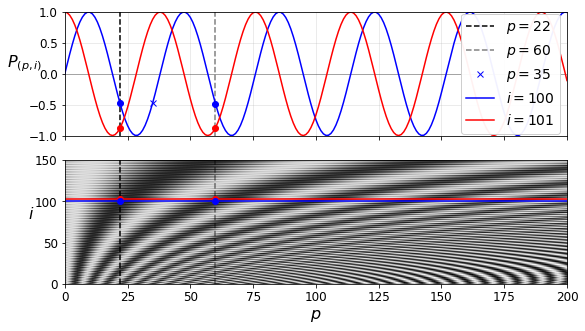

In [10]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [12]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here's a basic impolimentation of the ```MultiHeadAttention``` layer. One will likely be added to ```keras.layers``` in the near future. Note that ```Conv1D``` layers with ```kernel_size=1``` (and the default ```padding="valid"``` and ```strides=1```) is equivalent to a ```TimeDistributed(Dense(...))``` layer.

In [21]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
  def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
    self.n_heads = n_heads
    self.causal = causal
    self.use_scale = use_scale
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.dims = batch_input_shape[0][-1]
    self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
    self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
    self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
    self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
    self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
    self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
    super().build(batch_input_shape)
  def _multi_head_linear(self, inputs, linear):
    shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
    projected = K.reshape(linear(inputs), shape)
    perm = K.permute_dimensions(projected, [0, 2, 1, 3])
    return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
  def call(self, inputs):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v
    shape = K.shape(q)
    q_proj = self._multi_head_linear(q, self.q_linear)
    v_proj = self._multi_head_linear(v, self.v_linear)
    k_proj = self._multi_head_linear(k, self.k_linear)
    multi_attended = self.attention([q_proj, v_proj, k_proj])
    shape_attended = K.shape(multi_attended)
    reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
    perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
    concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
    return self.out_linear(concat)

In [22]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

# Exercise

## 8 Embedded Reber grammars

In [4]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
  state = 0
  output = []
  while state is not None:
    index = np.random.randint(len(grammar[state]))
    production, state = grammar[state][index]
    if isinstance(production, list):
      production = generate_string(grammar=production)
    output.append(production)
  return "".join(output)

In [5]:
np.random.seed(42)

for _ in range(25):
  print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [6]:
np.random.seed(42)

for _ in range(25):
  print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

generate a string that respects the grammar, and we will corrupt it by changing just one charcter

In [7]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
  good_string = generate_string(grammar)
  index = np.random.randint(len(good_string))
  good_char = good_string[index]
  bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
  return good_string[:index] + bad_char + good_string[index+1:]

In [8]:
np.random.seed(42)

for _ in range(25):
  print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

In [9]:
# emdedding char
def string_to_ids(s, chars=POSSIBLE_CHARS):
  return [POSSIBLE_CHARS.index(c) for c in s]

In [10]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

now generate the dataset, with 50% good strings and 50% bad strings:

In [11]:
def generate_dataset(size):
  good_strings = [string_to_ids(generate_string(embedded_reber_grammar)) for  _ in range(size//2)]
  bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar)) for _ in range(size//2)]
  all_strings = good_strings + bad_strings
  X = tf.ragged.constant(all_strings, ragged_rank=1)
  y = np.array([[1.] for _ in range(len(good_strings))] +
               [[0.] for _ in range(len(bad_strings))])
  return X, y

In [12]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [13]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

In [14]:
y_train[0]

array([1.])

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 6s 18ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 6s 20ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 4s 14ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 4s 13ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 4s 13ms/step - loss: 0.4016 - accuracy: 0.8262 - val_loss: 0.4032 - val_accuracy: 0.8120
Epoch 8/20

In [16]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.15%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.97%


## 9 Train an Encoder-Decoder model that can convert a date string from one format to another.

In [2]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
  min_date = date(1000, 1, 1).toordinal()
  max_date = date(9999, 12, 31).toordinal()

  ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
  dates = [date.fromordinal(ordinal) for ordinal in ordinals]

  x = [MONTHS[dt.month-1] + " " + dt.strftime("%d, %Y") for dt in dates]
  y = [dt.isoformat() for dt in dates]
  return x, y

In [3]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [4]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "0123456789, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy0123456789, '

In [5]:
OUTPUT_CHARS = "0123456789-"

In [6]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
  return [chars.index(c) for c in date_str]

In [7]:
date_str_to_ids(x_example[0])

[7, 11, 19, 22, 11, 16, 9, 11, 20, 37, 28, 26, 36, 37, 33, 26, 33, 31]

In [8]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [9]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
  X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
  X = tf.ragged.constant(X_ids, ragged_rank=1)
  return (X+1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
  x, y = random_dates(n_dates)
  return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [10]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [11]:
Y_train.shape

TensorShape([10000, 10])

### First version: basic seq2seq model

In [12]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim = embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS)+1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 13s 41ms/step - loss: 1.7955 - val_loss: 1.3513
Epoch 2/20
313/313 [==============================] - 12s 40ms/step - loss: 1.2933 - val_loss: 1.1348
Epoch 3/20
313/313 [==============================] - 13s 40ms/step - loss: 1.0733 - val_loss: 0.9109
Epoch 4/20
313/313 [==============================] - 12s 39ms/step - loss: 0.7964 - val_loss: 0.6749
Epoch 5/20
313/313 [==============================] - 13s 40ms/step - loss: 0.7810 - val_loss: 0.5758
Epoch 6/20
313/313 [==============================] - 13s 40ms/step - loss: 0.7051 - val_loss: 0.4820
Epoch 7/20
313/313 [==============================] - 12s 39ms/step - loss: 0.3950 - val_loss: 0.3390
Epoch 8/20
313/313 [==============================] - 12s 39ms/step - loss: 0.3356 - val_loss: 0.2460
Epoch 9/20
313/313 [==============================] - 12s 39ms/step - loss: 0.1894 - val_loss: 0.1464
Epoch 10/20
313/313 [==============================] - 12s 39ms/step - loss: 0.115

In [13]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [14]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2009-09-17
1789-07-14


Since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [15]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-02-14


we need to ensure that we always pass sequences of the same lenght as during training, using padding if necessary.

In [16]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
  X = prepare_date_strs(date_strs)
  if X.shape[1] < max_input_length:
    X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
  return X

def convert_date_strs(date_strs):
  X = prepare_date_strs_padded(date_strs)
  ids = model.predict_classes(X)
  return ids_to_date_strs(ids)


In [17]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

### Second version: feeding the shifted targets to the encoder (teacher forcing)

predict one character at a time, start with an sos token, then feeding the decoder all the characters that were predicted so far

In [18]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
  sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
  return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [19]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

In [20]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS)+1,
    output_dim = encoder_embedding_size
)(encoder_input)

_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True
)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size
)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 12s 39ms/step - loss: 1.6847 - accuracy: 0.3744 - val_loss: 1.4174 - val_accuracy: 0.4638
Epoch 2/10
313/313 [==============================] - 12s 38ms/step - loss: 1.2021 - accuracy: 0.5575 - val_loss: 0.9748 - val_accuracy: 0.6436
Epoch 3/10
313/313 [==============================] - 11s 37ms/step - loss: 0.6212 - accuracy: 0.7829 - val_loss: 0.9875 - val_accuracy: 0.6988
Epoch 4/10
313/313 [==============================] - 12s 37ms/step - loss: 0.2020 - accuracy: 0.9544 - val_loss: 0.0927 - val_accuracy: 0.9893
Epoch 5/10
313/313 [==============================] - 11s 37ms/step - loss: 0.0769 - accuracy: 0.9910 - val_loss: 0.0381 - val_accuracy: 0.9991
Epoch 6/10
313/313 [==============================] - 11s 36ms/step - loss: 0.0260 - accuracy: 0.9996 - val_loss: 0.0196 - val_accuracy: 0.9998
Epoch 7/10
313/313 [==============================] - 12s 37ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy:

In [21]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [22]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

### Third version: using TF-Addons's seq2seq implementation



In [28]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32

units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size
)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size
)

decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)

final_outputs, final_sate, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state
)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs = [Y_proba])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer= optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 12s 39ms/step - loss: 1.6774 - accuracy: 0.3673 - val_loss: 1.5041 - val_accuracy: 0.3938
Epoch 2/15
313/313 [==============================] - 11s 37ms/step - loss: 1.3724 - accuracy: 0.4712 - val_loss: 1.2208 - val_accuracy: 0.5393
Epoch 3/15
313/313 [==============================] - 12s 37ms/step - loss: 0.9477 - accuracy: 0.6564 - val_loss: 0.6660 - val_accuracy: 0.7654
Epoch 4/15
313/313 [==============================] - 12s 38ms/step - loss: 0.4154 - accuracy: 0.8685 - val_loss: 0.1874 - val_accuracy: 0.9656
Epoch 5/15
313/313 [==============================] - 12s 37ms/step - loss: 0.1298 - accuracy: 0.9805 - val_loss: 0.4355 - val_accuracy: 0.8551
Epoch 6/15
313/313 [==============================] - 12s 37ms/step - loss: 0.0485 - accuracy: 0.9969 - val_loss: 0.0322 - val_accuracy: 0.9994
Epoch 7/15
313/313 [==============================] - 12s 37ms/step - loss: 0.0217 - accuracy: 0.9997 - val_loss: 0.0167 - val_accuracy:

In [29]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

During inference, we've run the model once fro each new character. Instead, we can create a new decoder, based on the previously trained layers, but using a ```GreedyEmbeddingSampler``` instead of a ```TrainingSampler```.

At each time step, the ```GreedyEmbeddingSampler``` will compute the argmax of the decoder's outputs, and run the resulting token IDs through the deocder's embedding layer. Then it will feed the resultging embeddings to the decoder's LSTM cell at the next time step. This way, we only need to run the decoder once to get the full prediction.

In [30]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn = decoder_embedding_layer
)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length
)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value = sos_id)
final_outputs, final_state, final_sequence_lengths=inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0
)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

A few notes:
* The `GreedyEmbeddingSampler` needs the `start_tokens` (a vector containing the start-of-sequence ID for each decoder sequence), and the `end_token` (the decoder will stop decoding a sequence once the model outputs this token
* We must set `maximum_iterations` when creating the `BasicDecoder`, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter Kernel.
* The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from previous time step.
* The model's outputs are `final_outputs.sample_id` instead of the softmax of `final_outputs.rnn_outputs`. This allows us to directly get the argmax of the model's outputs. If you prefer to have access to the logits, you can replace `final_outputs.sample_id` with `final_outputs.rnn_outputs`.

Now we can write a simple function that uses the model to perform the date format conversion:

In [31]:
def fast_predict_date_strs(date_strs):
  X = prepare_date_strs_padded(date_strs)
  Y_pred = inference_model.predict(X)
  return ids_to_date_strs(Y_pred)

In [32]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [33]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

1 loop, best of 3: 426 ms per loop


In [34]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

10 loops, best of 3: 41 ms per loop


### Fourth version: using TF-Addons's seq2seq implementation with a scheduled sampler

only work on TensorFlower 2.2

when we trained the previous model, at each time step t we gave the model the target token for time step t-1. However, at inference time, the model did not get the previous target at each time step. Instead, it got the previous prediction. So there is a discrepancy between training and inference, which may lead to disappointing performance. To alleviate this, we can gradually replace the targets with predictions, during training. For this, we just need to replace the `TrainingSampler` with a `ScheduledEmbeddingTrainingSampler`, and use a keras. callback to gradually increase the `sampling_probability` (i.e., the probability that the decoder will use the prediction from the previous time step rather than the target for the previous time stpe).

In [35]:
tf.__version__

'2.3.0'

In [36]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 13s 42ms/step - loss: 1.6773 - accuracy: 0.3673 - val_loss: 1.5088 - val_accuracy: 0.3905
Epoch 2/20
313/313 [==============================] - 12s 39ms/step - loss: 1.3917 - accuracy: 0.4608 - val_loss: 1.2728 - val_accuracy: 0.5129
Epoch 3/20
313/313 [==============================] - 12s 40ms/step - loss: 1.0011 - accuracy: 0.6296 - val_loss: 0.7776 - val_accuracy: 0.7161
Epoch 4/20
313/313 [==============================] - 12s 39ms/step - loss: 0.6151 - accuracy: 0.7739 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 5/20
313/313 [==============================] - 12s 39ms/step - loss: 0.3386 - accuracy: 0.8857 - val_loss: 0.2534 - val_accuracy: 0.9234
Epoch 6/20
313/313 [==============================] - 12s 39ms/step - loss: 0.1975 - accuracy: 0.9437 - val_loss: 0.1463 - val_accuracy: 0.9613
Epoch 7/20
313/313 [==============================] - 13s 40ms/step - loss: 0.1690 - accuracy: 0.9584 - val_loss: 0.1089 - val_accuracy: 0.9744
Epo

`softmax_temperature` argument servers the same purpose as when we generated Shakespeare-like text (the higher this argument, the more random the generated text will be).

In [37]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [38]:
def creative_predict_date_strs(date_strs, temperature=1.0):
  softmax_temperature.assign(temperature)
  X = prepare_date_strs_padded(date_strs)
  Y_pred = inference_model.predict(X)
  return ids_to_date_strs(Y_pred)

In [39]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [40]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['3489507-12', '8282-21-01']

### Fifth version: using TFA seq2seq, the keras subclassing API and attention mechanisms

The sequences in this problem are pretty short, but if we wanted to tackle longer sequences, we would probably have to use attention mechanisms. While it's possible to code our own implementation, it's simpler and more efficient to use TF-Addibs's implementation instead. Let's do that now, this time using keras' subclassing API.

In this implementation, we've reverted back to using the `TrainingSampler`, for simplicity (but you can easily tweak it to use a `ScheduledEmbeddingTrainingSampler` instead). We also use a `GreedyEmbeddingSampler` during inference, so this class is pretty easy to use:

In [49]:
class DateTranslation(keras.models.Model):
  def __init__(self, units=128, encoder_embedding_size=32,
               decoder_embedding_size=32, **kwargs):
    super().__init__(**kwargs)
    self.encoder_embedding = keras.layers.Embedding(
        input_dim=len(INPUT_CHARS)+1,
        output_dim=encoder_embedding_size
    )
    self.encoder = keras.layers.LSTM(units,
                                     return_sequences=True,
                                     return_state=True)
    self.decoder_embedding = keras.layers.Embedding(
        input_dim=len(OUTPUT_CHARS)+2,
        output_dim=decoder_embedding_size
    )
    self.attention = tfa.seq2seq.LuongAttention(units)
    decoder_inner_cell = keras.layers.LSTMCell(units)
    self.decoder_cell = tfa.seq2seq.AttentionWrapper(
        cell=decoder_inner_cell,
        attention_mechanism=self.attention
    )
    output_layer = keras.layers.Dense(len(OUTPUT_CHARS)+1)
    self.decoder = tfa.seq2seq.BasicDecoder(
        cell=self.decoder_cell,
        sampler=tfa.seq2seq.sampler.TrainingSampler(),
        output_layer=output_layer
    )
    self.inference_decoder = tfa.seq2seq.BasicDecoder(
        cell=self.decoder_cell,
        sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
            embedding_fn=self.decoder_embedding
        ),
        output_layer=output_layer,
        maximum_iterations=max_output_length
    )
  def call(self, inputs, training=None):
    encoder_input, decoder_input = inputs
    encoder_embeddings = self.encoder_embedding(encoder_input)
    encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
        encoder_embeddings,
        training=training
    )
    encoder_state = [encoder_state_h, encoder_state_c]

    self.attention(encoder_outputs,
                   setup_memory=True)
    
    decoder_embeddings = self.decoder_embedding(decoder_input)

    decoder_initial_state = self.decoder_cell.get_initial_state(
        decoder_embeddings
    )
    decoder_initial_state = decoder_initial_state.clone(
        cell_state=encoder_state
    )

    if training:
      decoder_outputs, _, _ = self.decoder(
          decoder_embeddings,
          initial_state=decoder_initial_state,
          training=training
      )
    else:
      start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
      decoder_outputs, _, _ = self.inference_decoder(
          decoder_embeddings,
          initial_state=decoder_initial_state,
          start_tokens=start_tokens,
          end_token=0
      )
    return tf.nn.softmax(decoder_outputs.rnn_output)

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 17s 54ms/step - loss: 2.1427 - accuracy: 0.2296 - val_loss: 2.0216 - val_accuracy: 0.2663
Epoch 2/25
313/313 [==============================] - 16s 51ms/step - loss: 1.9566 - accuracy: 0.2904 - val_loss: 1.6023 - val_accuracy: 0.4058
Epoch 3/25
313/313 [==============================] - 16s 51ms/step - loss: 1.6510 - accuracy: 0.3917 - val_loss: 1.3964 - val_accuracy: 0.5153
Epoch 4/25
313/313 [==============================] - 16s 51ms/step - loss: 1.4313 - accuracy: 0.4818 - val_loss: 1.3057 - val_accuracy: 0.5256
Epoch 5/25
313/313 [==============================] - 16s 51ms/step - loss: 1.2540 - accuracy: 0.5387 - val_loss: 1.1966 - val_accuracy: 0.5411
Epoch 6/25
313/313 [==============================] - 17s 56ms/step - loss: 1.2809 - accuracy: 0.5210 - val_loss: 1.1848 - val_accuracy: 0.5456
Epoch 7/25
313/313 [==============================] - 16s 52ms/step - loss: 1.1665 - accuracy: 0.5518 - val_loss: 1.1597 - val_accuracy:

To use the model, we can write yet another little function.

In [53]:
def fast_predict_date_strs_v2(date_strs):
  X = prepare_date_strs_padded(date_strs)
  X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
  Y_probas = model.predict([X, X_decoder])
  Y_pred = tf.argmax(Y_probas, axis=-1)
  return ids_to_date_strs(Y_pred)

In [54]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

## 11 Use one of the recent language models to generate more convincing Shakespearean text.

In [56]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 2.9MB 27.2MB/s 
     |████████████████████████████████| 1.1MB 40.5MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4b055c6e1d1dc8b58ccebaf569a7a262daac16fd240874b6c5e6555d5542fbe4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [58]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

ValueError: ignored

In [59]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

ValueError: ignored

In [ ]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt